In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import random
from scipy import stats
from sklearn import linear_model

/Users/crhanlon/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/crhanlon/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/crhanlon/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/crhanlon/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Data Ingestion

### Constants

In [3]:
# Excluding wind speed due to input error
DISCRETE_PREDICTORS = ['YardLine', 'Quarter', 'Down', 'Distance', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'DefendersInTheBox', 'PlayerWeight', 'Week', 'Temperature', 'Humidity']

### Data Reading

In [4]:
total_df = pd.read_csv(open('../data/train.csv', 'r'))

/Users/crhanlon/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Have copy of DataFrame that is only the rusher's row.  Good for general analysis

In [5]:
rusher_df = total_df[total_df['NflId'] == total_df['NflIdRusher']]

### Data Transformation

We need to transform the data in multiple ways
1. Change the team name abbreviations that are inconsistent
2. Change the home/away, team name abbreviations to be same.  Should have
    1. Home/Away
    2. Player's Team
    3. Opposing team
    4. Side of field it's on (left/right)
3. Standardize everything to go left to right.  If originally going R -> L, need to change
    1. X
    2. Direction
    3. Orientation
    4. YardLine
4. Change the height to number
5. Isolate time info (play, birth date)
    1. Year
    2. Month
    3. Day
    4. Time to single number

In [6]:
# Change the FieldPosition/PossessionTeam columns to match the VisitorTeamAbbr, HomeTeamAbbr
TEAM_TRANSFORMATION = {
    'ARZ': 'ARI',
    'BLT': 'BAL',
    'CLV': 'CLE',
    'HST': 'HOU'
}

def new_team(team):
    if team in TEAM_TRANSFORMATION:
        return TEAM_TRANSFORMATION[team]
    return team

new_fp = total_df['FieldPosition'].map(new_team)
total_df['FieldPosition'] = new_fp
new_pt = total_df['PossessionTeam'].map(new_team)
total_df['PossessionTeam'] = new_pt

In [7]:
# TODO: Augment the matrix with parsed results (# of each position on field, yards from own end zone)

## Play Level

### Transformation

In [8]:
def flip_angle(angle):
    return (180 - angle) % 360
#     if angle <= 90 or angle >= 270:
#         return (-1*angle) % 360
#     return (angle - 2*(angle - 180))
    
def _augment_matrix(play_df):
    """
    inputs:
        play_df (pandas DataFrame): DataFrame containing all play information
    outputs:
        augmented_df (pandas DataFrame): DataFrame containing augmented information
    """
    augmented_df = play_df.copy()
    
    # Identify the rusher
    runner_id = play_df.iloc[0]['NflIdRusher']
    runner_row = play_df[play_df['NflId'] == runner_id]
    if runner_row.shape[0] != 1:
        raise Exception('Incorrect runner matching')
    runner_row = runner_row.iloc[0]
    
    # Identify the team that has possession
    possession_team_ha = runner_row['Team']
    
    # Determine whether the ball is on the home/road team's side of the field
    home_team = runner_row['HomeTeamAbbr']
    field_pos_home = 'away'
    if augmented_df.iloc[0]['FieldPosition'] == home_team:
        field_pos_home = 'home'
    
    # Flip if necessary
    if runner_row['PlayDirection'] == 'left':
        augmented_df['standardX'] = play_df['X'] - 2*(play_df['X'] - 60)
        augmented_df['standardY'] = play_df['Y'] - 2*(play_df['Y'] - 53.3/2)
        augmented_df['standardOrientation'] = play_df['Orientation'].apply(flip_angle)
        augmented_df['standardDir'] = play_df['Dir'].apply(flip_angle)
    else:
        augmented_df['standardX'] = play_df['X']
        augmented_df['standardY'] = play_df['Y']
        augmented_df['standardOrientation'] = play_df['Orientation']
        augmented_df['standardDir'] = play_df['Dir']
    # Modify the yard line as necessary
    # It is before the 50 if the runner is home and the FieldPosition is home or if the runner is away and FieldPosition is away
    # It is after the 50 if the runner is home and the FieldPosition is away or if the runner is away and FieldPosition is home
    if field_pos_home == possession_team_ha:
        augmented_df['standardYardLine'] = play_df['YardLine'] + 10
    else:
        augmented_df['standardYardLine'] = 110 - play_df['YardLine']
    
    # End result of play
    augmented_df['standardEndYardLine'] = augmented_df['standardYardLine'] + augmented_df['Yards']
    
    # Indicates if the player is on offense
    augmented_df['isOffense'] = augmented_df['Team'] == possession_team_ha
    # Indicates the side of the field relative to home/road team
    augmented_df['fieldPositionHome'] = field_pos_home
    # Indicates if the player is the rusher
    augmented_df['isRusher'] = augmented_df['NflId'] == runner_id
    return augmented_df

### Plotting

In [9]:
def plot_augmented_df(augmented_df, zoom=False):
    """
    inputs:
        augmented_df(pandas DataFrame): play's augmented dataframe
    outputs:
        figure (pyplot figure): figure of play
    """
    # Subset dataframe
    non_rushing_df = augmented_df[~augmented_df['isRusher']]
    rushing_df = augmented_df[augmented_df['isRusher']]
    offense_df = non_rushing_df[non_rushing_df['isOffense']]
    defense_df = non_rushing_df[~non_rushing_df['isOffense']]
    
    # Identify player coordinates
    off_x = offense_df['standardX']
    off_y = offense_df['standardY']
    rush_x = rushing_df['standardX']
    rush_y = rushing_df['standardY']
    def_x = defense_df['standardX']
    def_y = defense_df['standardY']
    
    # Line of scrimmage
    los = rushing_df.iloc[0]['standardYardLine']
    
    # End yard line
    eyl = rushing_df.iloc[0]['standardEndYardLine']
    
    # Initialize figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 5])
#     fig = plt.figure(1, figsize=[12, 5])
    
    # Plot yard lines
    ax1.plot([0, 120], [0, 0], c='k')
    ax1.plot([0, 120], [53.3, 53.3], c='k')
    ax1.plot([0, 0], [0, 53.3], c='k')
    ax1.plot([10, 10], [0, 53.3], c='k')
    ax1.plot([110, 110], [0, 53.3], c='k')
    ax1.plot([120, 120], [0, 53.3], c='k')
    for i in range(15, 106, 5):
        if i == 60:
            ax1.plot([i, i], [0, 53.3], c='k', ls='-')
        else:
            ax1.plot([i, i], [0, 53.3], c='k', ls='--')
    
    # Plot LOS
    ax1.plot([los, los], [0, 53.3], c='m', ls='-')
    # Plot end yard
    ax1.plot([eyl, eyl], [0, 53.3], c='c', ls='-')
    
    # Plot players
    ax1.scatter(off_x, off_y, c='b')
    ax1.scatter(rush_x, rush_y, c='g')
    ax1.scatter(def_x, def_y, c='r')
    
    # Plot original to check
    # Plot yard lines
    ax2.plot([0, 120], [0, 0], c='k')
    ax2.plot([0, 120], [53.3, 53.3], c='k')
    ax2.plot([0, 0], [0, 53.3], c='k')
    ax2.plot([10, 10], [0, 53.3], c='k')
    ax2.plot([110, 110], [0, 53.3], c='k')
    ax2.plot([120, 120], [0, 53.3], c='k')
    for i in range(15, 106, 5):
        if i == 60:
            ax2.plot([i, i], [0, 53.3], c='k', ls='-')
        else:
            ax2.plot([i, i], [0, 53.3], c='k', ls='--')
    ax2.scatter(offense_df['X'], offense_df['Y'], c='b')
    ax2.scatter(rushing_df['X'], rushing_df['Y'], c='g')
    ax2.scatter(defense_df['X'], defense_df['Y'], c='r')
    plt.show()

20181202103694


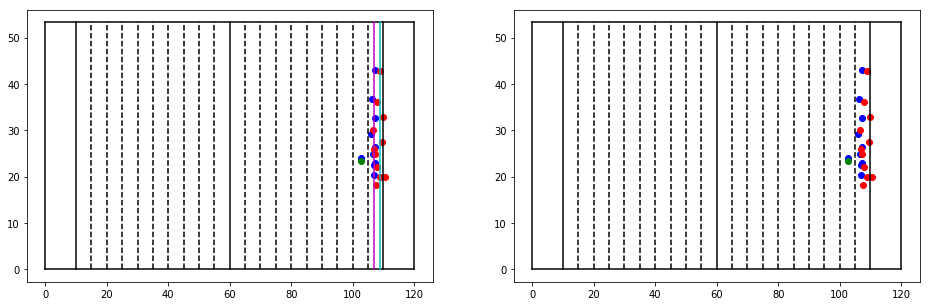

20181125032932


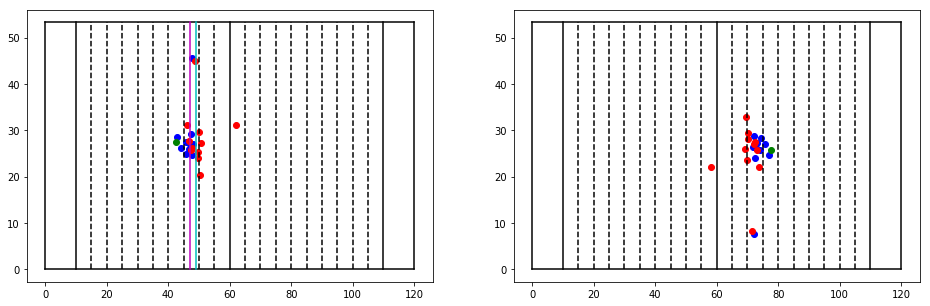

20171001020318


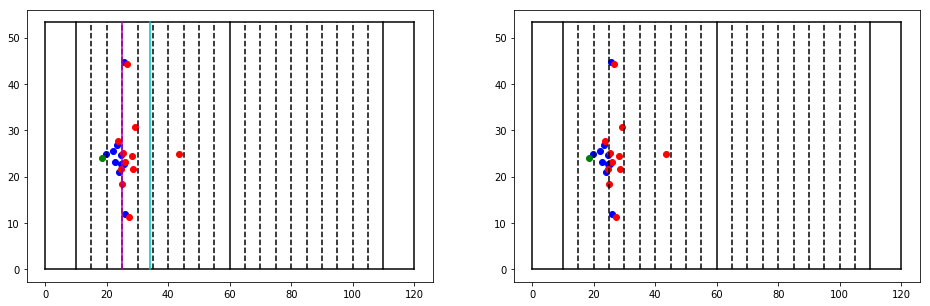

20181209062487


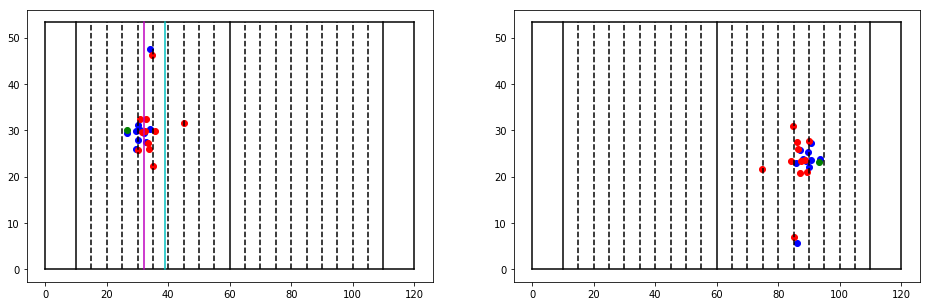

20181028063351


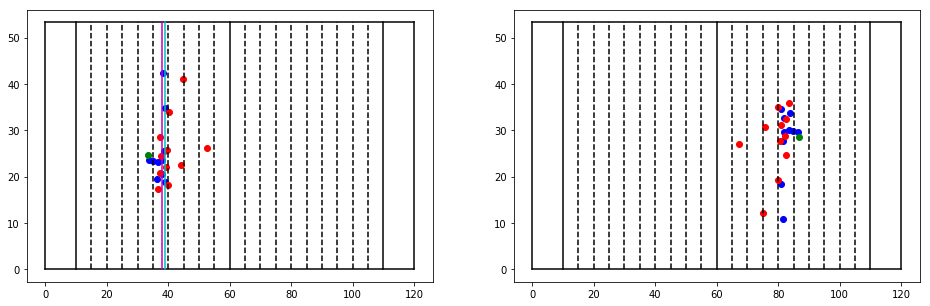

20181104050658


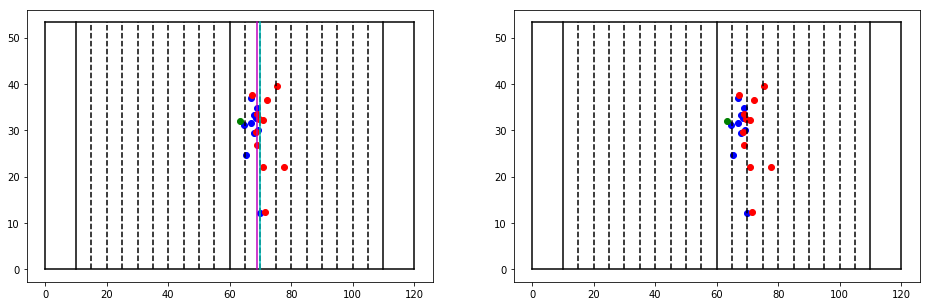

20171119050667


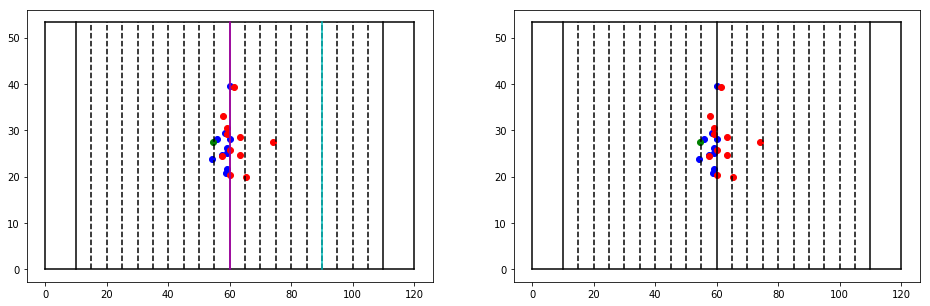

20171112032580


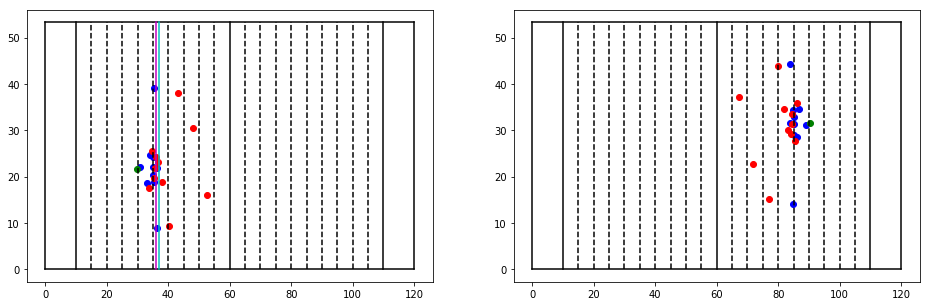

20181216083355


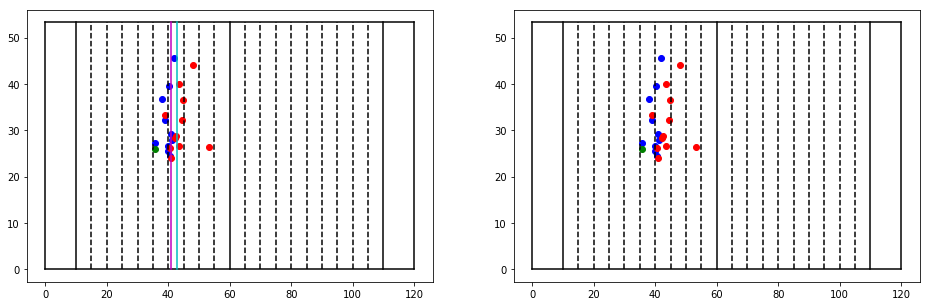

20181223003118


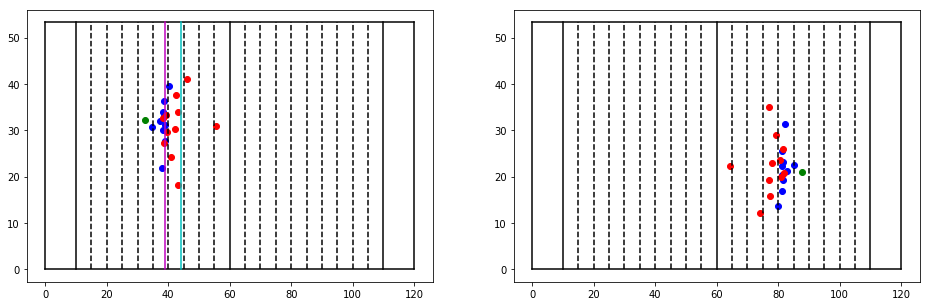

20171029050300


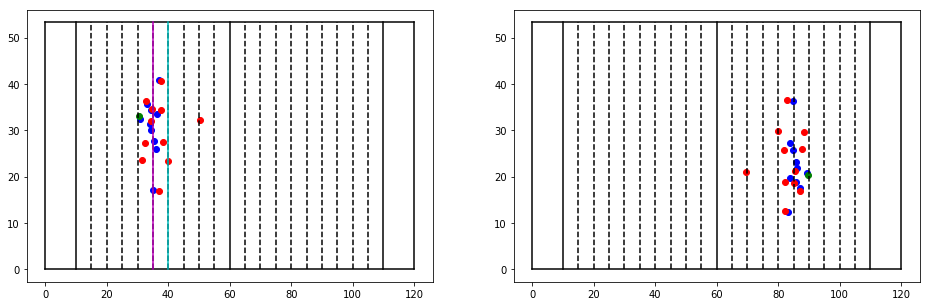

20181118031133


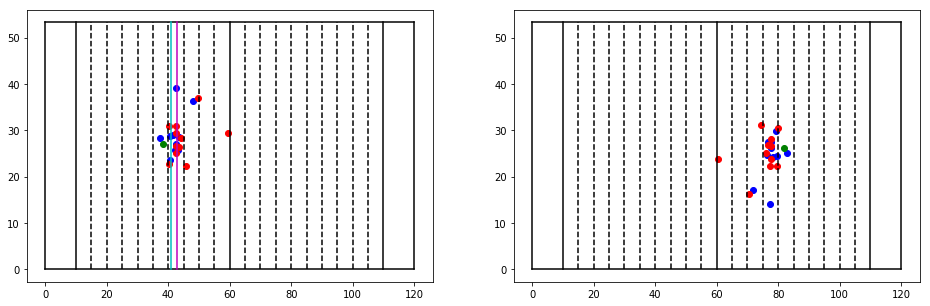

20181223133770


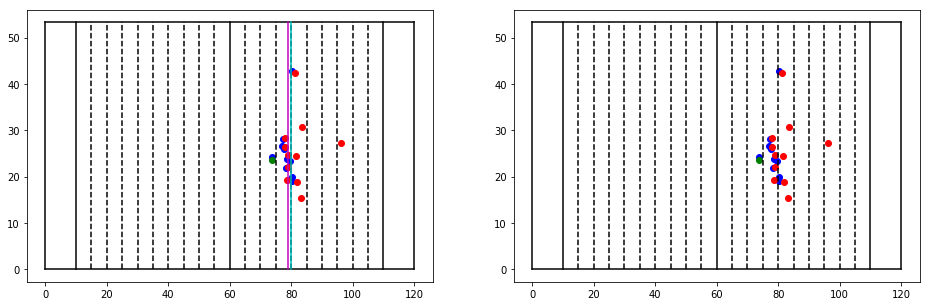

20181216061322


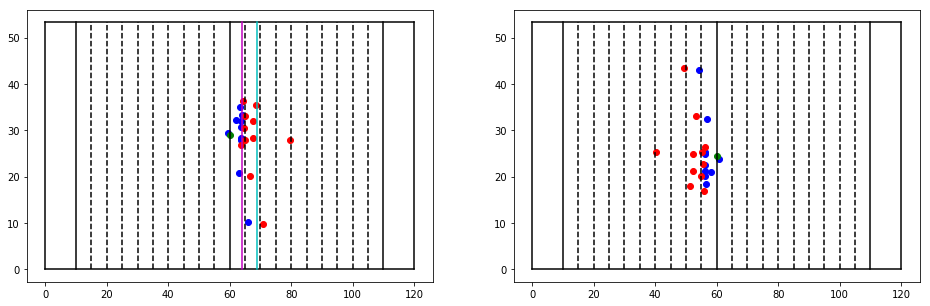

20181216070920


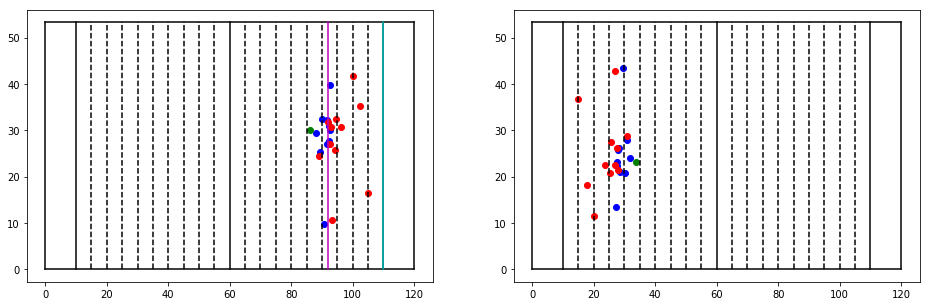

20181014053218


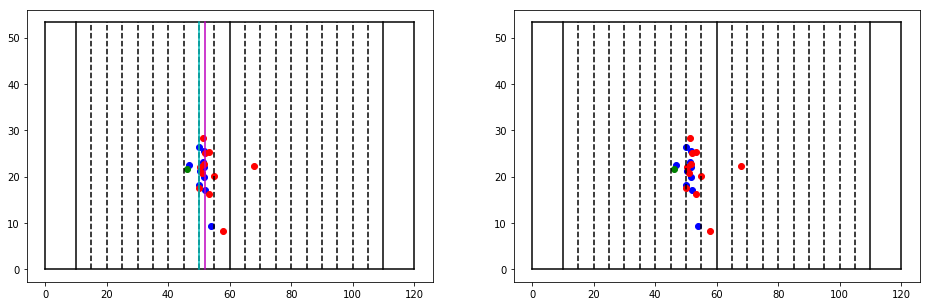

20180909090725


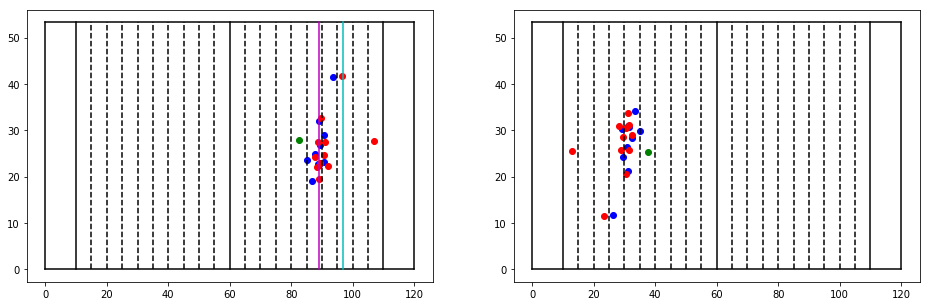

20181118083736


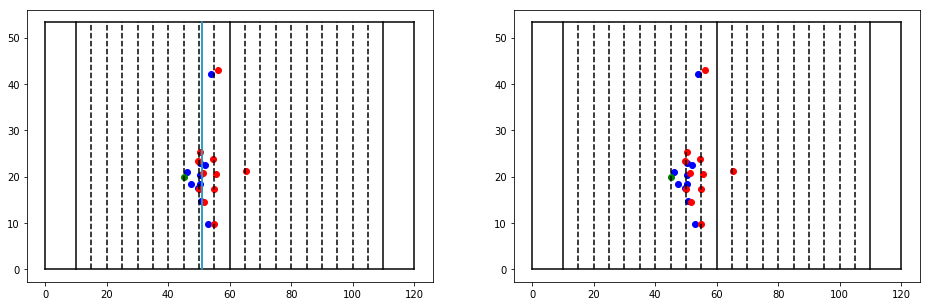

20170910102582


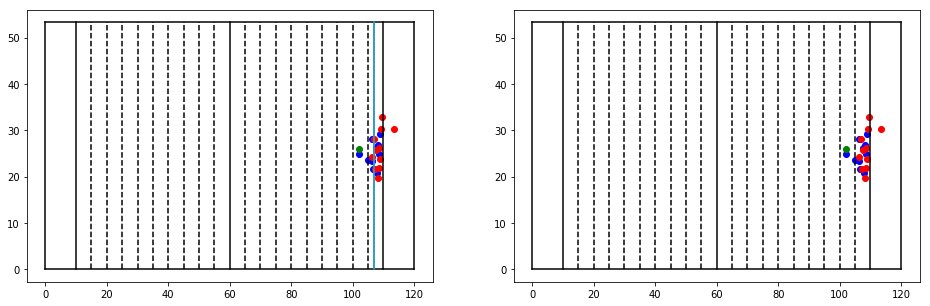

20171210024229


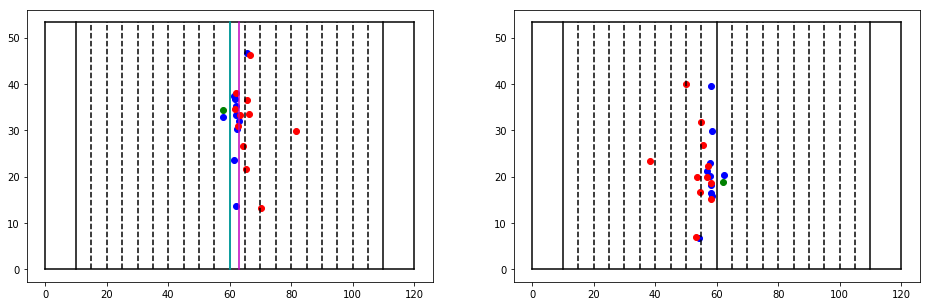

20181122002528


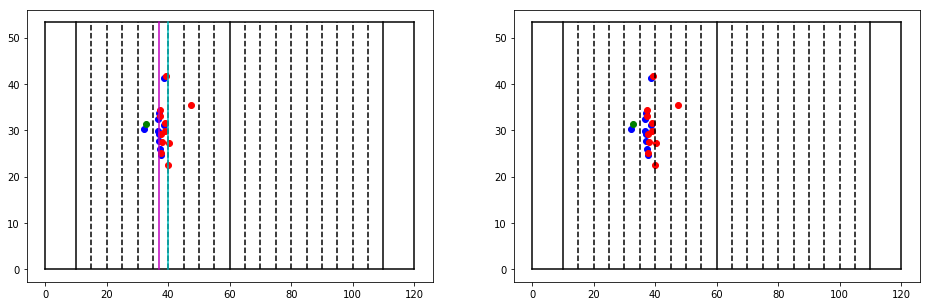

20181202102810


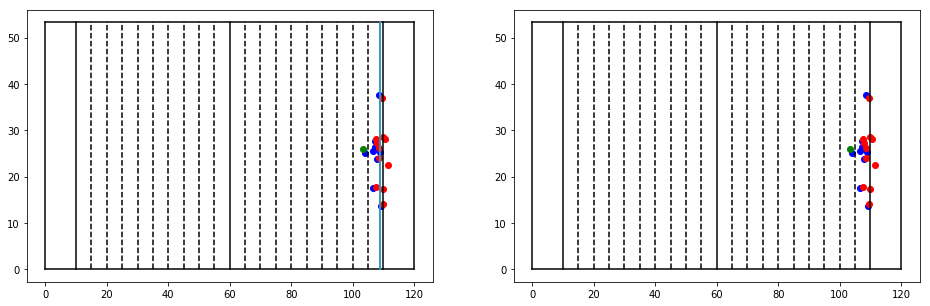

20170914002596


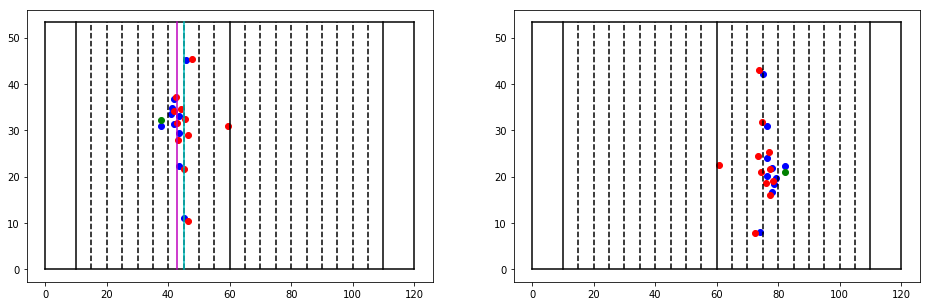

20181007113716


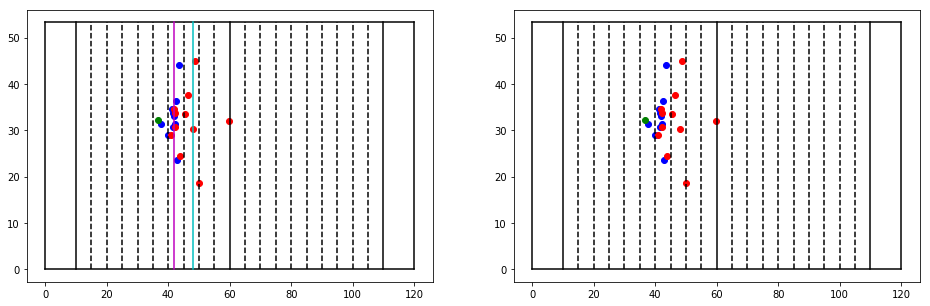

20171029020272


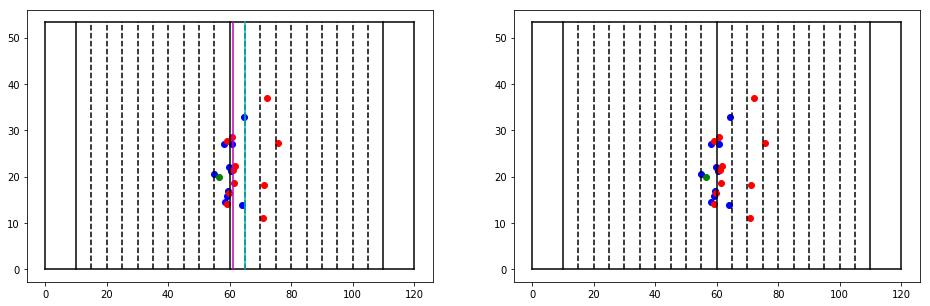

In [10]:
play_id_list = np.random.choice(total_df['PlayId'].unique(), 25)
for p_id in play_id_list:
    play_df = total_df[total_df['PlayId'] == p_id]
    augmented_df = _augment_matrix(play_df)
    print(p_id)
    plot_augmented_df(augmented_df)

## Data Overview

In [11]:
def get_lin_fit(x_vals, y_vals):
    # Calculate lin regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals, y_vals)
    return slope, intercept, r_value, p_value, std_err

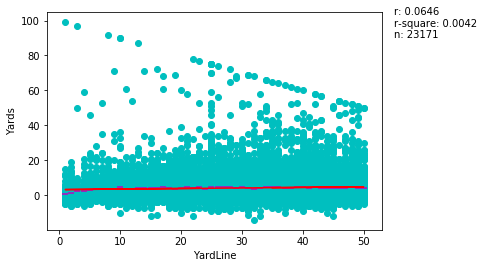

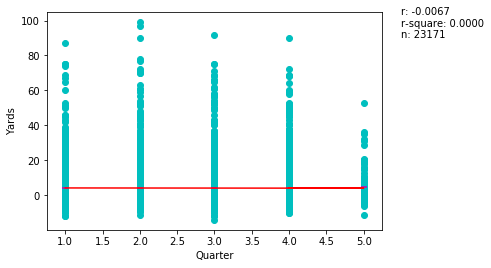

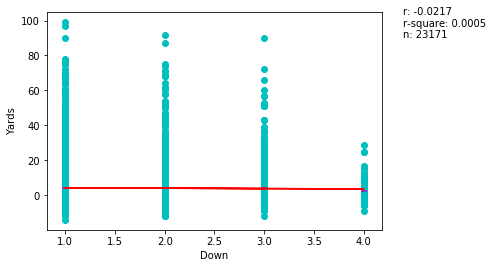

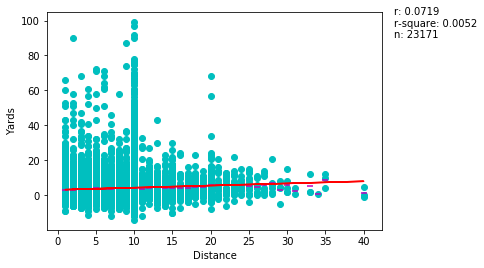

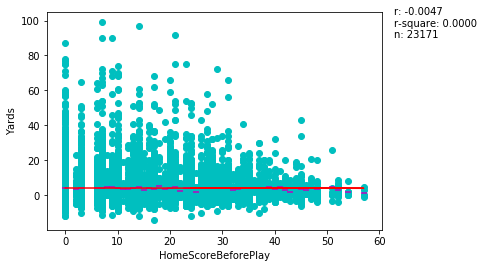

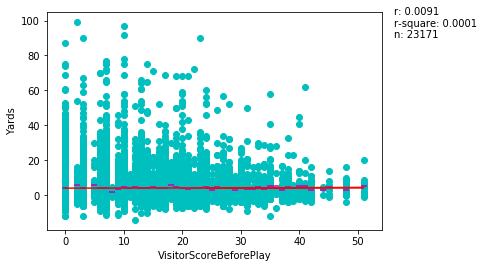

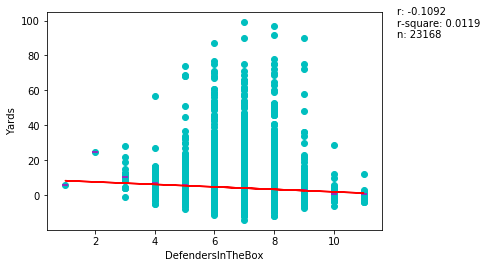

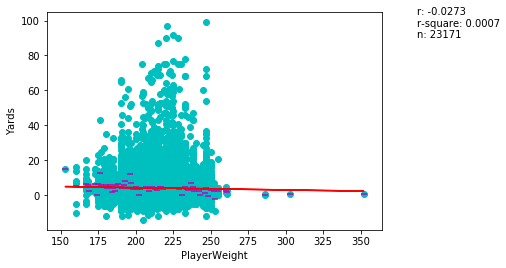

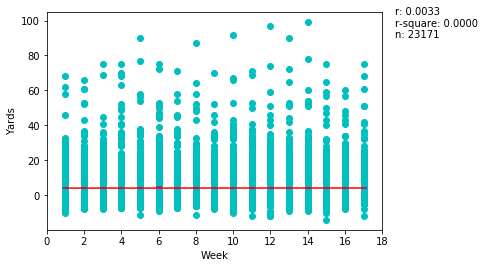

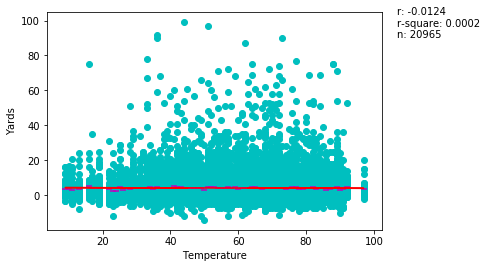

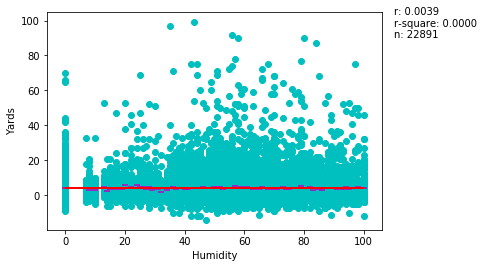

In [12]:
for p in DISCRETE_PREDICTORS:
    fig = plt.figure()
    # Isolate the values
    x_vals = rusher_df[p]
    y_vals = rusher_df['Yards']
    data_tuples = list(zip(x_vals, y_vals))
    xy_df = pd.DataFrame(data=data_tuples, columns=['X', 'Y'])
    xy_df = xy_df.dropna()
    
    
    # Get the best fit
    slope, intercept, r_value, _, _ = get_lin_fit(xy_df['X'], xy_df['Y'])
    y_pred = xy_df['X']*slope + intercept
    plt.scatter(xy_df['X'], xy_df['Y'], c='c')
    
    mean_x = []
    mean_y = []
    for x_val in xy_df['X'].unique():
        mask = xy_df['X'] == x_val
        reduced_y = xy_df['Y'][mask]
        mean_x.append(x_val)
        mean_y.append(np.mean(reduced_y))
    
    plt.scatter(mean_x, mean_y, c='m', marker='_')
    plt.plot(xy_df['X'], y_pred, c='r')
    plt.text(x=1.1*max(x_vals), y=90, s='r: ' + "{0:.4f}".format(r_value) + '\nr-square: ' + "{0:.4f}".format(r_value**2) + '\nn: ' + str(len(xy_df['X'])))
    
    
    # Add labels
    plt.xlabel(p)
    plt.ylabel('Yards')
    plt.show()

### Yards Summary

In [13]:
yards = rusher_df['Yards']

In [14]:
yards_mean = np.mean(yards)
yards_median = np.median(yards)
yards_std = np.std(yards)

In [15]:
print('mean: {}'.format(yards_mean))
print('median: {}'.format(yards_median))
print('standard dev: {}'.format(yards_std))

mean: 4.2123343834966125
median: 3.0
standard dev: 6.436160692962253


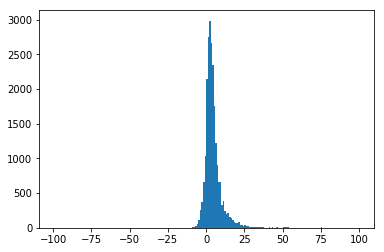

In [16]:
vals, bins, patches = plt.hist(rusher_df['Yards'], bins=range(-99, 101))

## First Models

### Evaluation

In [67]:
def heavyside_step(x):
    if x >= 0:
        return 1
    return 0

def calc_crps(real_list, predicted_dist_list):
    if len(real_list) != len(predicted_dist_list):
        raise Exception('Invalid lengths')
    
    total_crps_num = 0
    # Iterate through plays
    for m in range(len(real_list)):
        real_y = real_list.iloc[m]
        predicted_dist = predicted_dist_list[m]
#         print(predicted_dist)
        # Iterate through predicted values
        cum_prob = 0
        for n in range(-99, 100):
            predicted_prob = predicted_dist[n + 99]
#             print(n, predicted_prob)
            hs = heavyside_step(n - real_y)
            cum_prob += predicted_prob
            added_crps = (cum_prob - hs)**2
            total_crps_num += added_crps
#             print('Predicted Yard: {}, Prob: {:.3f}, Real Yard: {}, cum_prob: {:.3f}, added crps: {:.3f}'.format(n, predicted_prob, real_y, cum_prob, added_crps))
        if cum_prob != 1:
            raise Excpeption('Invalid cum prob')
    return 1/(199*len(real_list))*total_crps_num

In [53]:
def get_predictions_mod(predictions):
    predictions_mod = []
    for m in predictions:
        new_pred = []
        for i in range(-99, 100):
            if i - m == 0:
                new_pred.append(1)
            elif i - m > -1 and i - m < 0:
                new_pred.append(1 - (m - i))
            elif i - m > 0 and i - m < 1:
                new_pred.append(1 - (i - m))
            else:
                new_pred.append(0)
        if len(new_pred) != 199:
            raise Exception('Predictions len inaccurate')
        if sum(new_pred) != 1:
            raise Exception('Predictions sum inaccurate')
        predictions_mod.append(new_pred)
    return predictions_mod

### Benchmark

In [54]:
Y = rusher_df['Yards']

In [55]:
benchmark_pred = pd.Series([3]*len(Y))

In [56]:
benchmark_pred_mod = get_predictions_mod(benchmark_pred)
print(benchmark_pred[0])
print(benchmark_pred_mod[0])

3
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [68]:
crps = calc_crps(Y, benchmark_pred_mod)
print('crps: {}'.format(str(crps)))
print('N: {}'.format(str(len(Y))))

crps: 0.018454665975859184
N: 23171


In [69]:
crps/0.01865

0.9895263257833342

### Linear Regression

In [70]:
# Input parameters
reduced_df = rusher_df[['YardLine', 'Down', 'Distance', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'DefendersInTheBox', 'Yards']]
print(reduced_df.shape)
reduced_df = reduced_df.dropna()
print(reduced_df.shape)
X = reduced_df[['YardLine', 'Down', 'Distance', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'DefendersInTheBox']]
Y = reduced_df['Yards']

(23171, 7)
(23168, 7)


In [71]:
lm = linear_model.LinearRegression()
model = lm.fit(X, Y)

In [72]:
predictions = lm.predict(X)

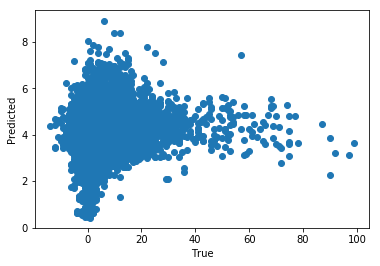

In [73]:
plt.scatter(Y, predictions)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

In [74]:
predictions_mod = get_predictions_mod(predictions)

In [75]:
crps = calc_crps(Y, predictions_mod)

In [76]:
crps

0.018207405164658748

In [77]:
print(Y[:5])

18    8
40    3
62    5
84    2
98    7
Name: Yards, dtype: int64


In [78]:
temp_df = pd.DataFrame(np.array(predictions_mod[4]))
temp_df[temp_df[temp_df.columns[0]] != 0]

,0
103,0.836067
104,0.163933
